## Process eval score

In [1]:
import json
import re
import os
import pandas as pd

df_eval = pd.DataFrame(columns=["model_name", "mode", "mission_name", "score"])
df_tp = pd.DataFrame(columns=["model_name", "mode", "mission_name", "z_score", "true_positive", "sum"])
df_tn = pd.DataFrame(columns=["model_name", "mode", "mission_name", "true_negative"])

input_dir = "./pred"
model_name = "llama2-7b-chat-4k"

mode0 = "llama2-7b-chat-4k_no_g0.5_d5.0"
mode1 = "llama2-7b-chat-4k_old_hard_g0.25_d5.0"
mode2 = "llama2-7b-chat-4k_old_soft_g0.1_d10.0"
mode3 = "llama2-7b-chat-4k_gpt_g0.1_d10.0"
mode4 = "llama2-7b-chat-4k_v2_g0.25_d15.0"

mode = [mode0, mode1, mode2, mode3, mode4]
mutual_mode = ["_".join(modex.split("_")[1:]) for modex in mode]
print(mutual_mode)

num_eval = 0
num_z = 0
p = r"(?P<model_name>.+)_(?P<mode>old|v2|gpt|new|no)_g(?P<gamma>.+)_d(?P<delta>\d+(\.\d+)?)"
p_z = r"(?P<mission_name>[a-zA-Z_]+)_(?P<gamma>\d+(\.\d+)?)_(?P<delta>.+)_z"
p_mutual_z = r"(?P<mission_name>[a-zA-Z_]+)_(?P<threshold>\d+(\.\d+)?)_z"

['no_g0.5_d5.0', 'old_hard_g0.25_d5.0', 'old_soft_g0.1_d10.0', 'gpt_g0.1_d10.0', 'v2_g0.25_d15.0']


In [2]:
# get all files from input_dir
for subfolder in os.listdir(input_dir):
    
    if "human" in subfolder:
        continue
    matcher = re.match(p, subfolder)
    
    model_name_now = matcher.group("model_name")
    if model_name_now != model_name:
        continue
    print("subfolder is:", subfolder)
    mode = matcher.group("mode")
    gamma = matcher.group("gamma")
    delta = matcher.group("delta")
    
    bl_type = "None"
    bl_type = (subfolder.split("_")[-1]).split(".")[0]
    
    if bl_type != "hard":
        if "old" in subfolder:
            bl_type = "soft"
        else:
            bl_type = "None"
        
    if bl_type == "hard" or bl_type == "soft":
        final_mode = model_name + "_" + mode + "_" + bl_type + "_" + "g"+gamma + "_" + "d" + delta  
    else:
        final_mode = model_name + "_" + mode + "_" + "g"+gamma + "_" + "d" + delta 
        
    eval_path = os.path.join(input_dir, subfolder, "eval")
    z_score_path = os.path.join(input_dir, subfolder, "z_score")
    threshold = 4.0
    if os.path.exists(z_score_path):
        temp_df = pd.DataFrame(columns=["model_name", "mode", "mission_name", "z_score", "true_positive", "sum"])
        all_z = []
        all_sum = []
        all_tp = 0
        
        
        files = os.listdir(z_score_path)
        for file in files:
            tp = 0
            matcher1 = re.match(p_z, file)
            
            if matcher1:
                mission_name = matcher1.group("mission_name")
            
            with open(os.path.join(z_score_path, file), "r") as f:
                data = json.load(f) 
                
            z_score_list = data["z_score_list"]
            _sum = len(data["z_score_list"])   
            tp += len([x for x in z_score_list if x > threshold])
            avarage_z = data["avarage_z"]
            temp = pd.DataFrame({
                "model_name": [model_name],
                "mode": [final_mode],
                "mission_name": [mission_name],
                "z_score": [avarage_z],
                "true_positive": [tp/_sum],
                "sum": [_sum]})
            
            df_tp = pd.concat([df_tp, temp], ignore_index=True)
            all_z.append(avarage_z * _sum)
            all_sum.append(_sum)
            all_tp += tp
            num_z += 1
            
        temp_df = pd.DataFrame({
            "model_name": [model_name],
            "mode": [final_mode],
            "mission_name": ["avarage_mode"],
            "z_score": [sum(all_z) / sum(all_sum)],
            "true_positive": [all_tp/sum(all_sum)], 
            "sum": [all_sum]
        })
        df_tp = pd.concat([df_tp, temp_df], ignore_index=True)   
         
    if os.path.exists(eval_path):
        result_file = os.path.join(eval_path, "result.json")
        if os.path.exists(result_file):
            with open (result_file, "r") as f:
                data = json.load(f)
            keys = data.keys()
            temp_df = pd.DataFrame(columns=["model_name", "mode", "mission_name", "score"])
            all_scores = []
            for key in keys:
                eval_score = float((str(data[key])).split(" ")[-1])
                temp_df = pd.DataFrame({
                    "model_name":[model_name],
                    "mode":[final_mode],
                    "mission_name": [key],
                    "score":[eval_score]
                })
                
                all_scores.append(eval_score)
                df_eval = pd.concat([df_eval, temp_df], ignore_index=True)
                
                num_eval += 1
                
            temp_df = pd.DataFrame({
                    "model_name":[model_name],
                    "mode":[final_mode],
                    "mission_name": ["avarage_mode"],
                    "score":[sum(all_scores) / len(keys)]
                })   
            
            df_eval = pd.concat([df_eval, temp_df], ignore_index=True) 
            

subfolder is: llama2-7b-chat-4k_gpt_g0.25_d10.0
subfolder is: llama2-7b-chat-4k_gpt_g0.1_d10.0
subfolder is: llama2-7b-chat-4k_old_g0.25_d15.0_hard
subfolder is: llama2-7b-chat-4k_old_g0.75_d5.0_hard
subfolder is: llama2-7b-chat-4k_v2_g0.25_d2.0
subfolder is: llama2-7b-chat-4k_old_g0.5_d2.0_hard
subfolder is: llama2-7b-chat-4k_old_g0.25_d5.0_hard
subfolder is: llama2-7b-chat-4k_gpt_g0.5_d5.0
subfolder is: llama2-7b-chat-4k_old_g0.1_d5.0
subfolder is: llama2-7b-chat-4k_v2_g0.25_d10.0
subfolder is: llama2-7b-chat-4k_v2_g0.1_d5.0
subfolder is: llama2-7b-chat-4k_old_g0.25_d10.0_hard
subfolder is: llama2-7b-chat-4k_v2_g0.9_d5.0
subfolder is: llama2-7b-chat-4k_old_g0.5_d2.0
subfolder is: llama2-7b-chat-4k_gpt_g0.5_d2.0
subfolder is: llama2-7b-chat-4k_gpt_g0.9_d5.0
subfolder is: llama2-7b-chat-4k_old_g0.25_d2.0
subfolder is: llama2-7b-chat-4k_old_g0.9_d5.0_hard
subfolder is: llama2-7b-chat-4k_gpt_g0.1_d5.0
subfolder is: llama2-7b-chat-4k_v2_g0.5_d5.0
subfolder is: llama2-7b-chat-4k_gpt_g0.25_

In [3]:
df_tp.to_csv("z_score_tp.csv")           
print(df_tp)
print(num_z)

df_eval = df_eval.sort_values(by="mode", ascending=True)                 
df_eval.to_csv("eval.csv")                
print("num is:", num_eval)

            model_name                                   mode  \
0    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
1    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
2    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
3    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
4    llama2-7b-chat-4k      llama2-7b-chat-4k_gpt_g0.25_d10.0   
..                 ...                                    ...   
399  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
400  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
401  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
402  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   
403  llama2-7b-chat-4k  llama2-7b-chat-4k_old_soft_g0.1_d10.0   

               mission_name    z_score  true_positive  \
0                     qmsum  18.372595       0.970000   
1                alpacafarm  24.303930       0.962733   
2                  hotpotqa   2.740259       0.2

### Calculate TN

In [4]:
input_dir = "./mutual_detect/llama2-7b-chat-4k/"

df_mutual = pd.DataFrame(columns=["model_name", "mission_name", "ref_mode", "det_mode", "threshold", "z_score", "true_negative", "sum", "tn_num"])

num = 0
for subfolder in os.listdir(input_dir):
    ref_mode = "_".join(subfolder.split("_")[1:])
    if ref_mode in mutual_mode:
        print("mode_des is", ref_mode)
        
        for subsubfolder in os.listdir(os.path.join(input_dir,subfolder)):
            det_mode = subsubfolder.split("_z")[0]
            print(det_mode)
            
            z_score_path = os.path.join(input_dir, subfolder, subsubfolder)
            if os.path.exists(z_score_path):
                files = os.listdir(z_score_path)
                
                all_z = []
                all_sum = []
                all_tn = 0
                
                for file in files:
                    tn = 0
                    matcher2 = re.match(p_mutual_z, file)
                    if matcher2:
                        mission_name = matcher2.group("mission_name")
                        threshold = float(matcher2.group("threshold"))
                        
                    with open(os.path.join(z_score_path, file), "r") as f:
                        data = json.load(f)
                        
                        
                    avarage_z = data["avarage_z"]
                    z_score_list = data["z_score_list"]
                    _sum = len(data["z_score_list"])
                    
                    tn += len([x for x in z_score_list if x <= threshold])
                    num += 1
                    
                    temp_df = pd.DataFrame({
                        "model_name": [model_name],
                        "ref_mode": [ref_mode],
                        "mission_name": [mission_name],
                        "det_mode":[det_mode],
                        "threshold": [threshold],
                        "z_score": [avarage_z],
                        "true_negative": [tn/_sum],
                        "tn_num": [tn],
                        "sum": [_sum]
                    })
                    all_tn += tn
                    all_z.append(avarage_z * _sum)
                    all_sum.append(_sum)
                    
                    df_mutual = pd.concat([df_mutual, temp_df], ignore_index=True)
                temp_df = pd.DataFrame({
                        "model_name": [model_name],
                        "ref_mode": [ref_mode],
                        "mission_name": ["avarage_mode"],
                        "det_mode":[det_mode],
                        "threshold": [threshold],
                        "z_score": [sum(all_z) / sum(all_sum)],
                        "true_negative": [all_tn/sum(all_sum)],
                        "tn_num": [all_tn],
                        "sum": [sum(all_sum)]
                    })
                
                df_mutual = pd.concat([df_mutual, temp_df], ignore_index=True)
                    
df_mutual.to_csv("mutual_z_contri.csv")

mode_des is old_soft_g0.1_d10.0
gpt_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_hard_g0.25_d5.0
old_soft_g0.25_d15.0
v2_g0.25_d15.0
mode_des is old_hard_g0.25_d5.0
old_soft_g0.1_d10.0
gpt_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_soft_g0.25_d15.0
v2_g0.25_d15.0
mode_des is gpt_g0.1_d10.0
old_soft_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_hard_g0.25_d5.0
old_soft_g0.25_d15.0
v2_g0.25_d15.0
mode_des is v2_g0.25_d15.0
old_soft_g0.1_d10.0
gpt_g0.1_d10.0
human_generation
no_g0.5_d5.0
old_hard_g0.25_d5.0
old_soft_g0.25_d15.0


### Human_Generation TN

In [5]:
df_det_human = df_mutual.loc[(df_mutual["det_mode"] == "human_generation")]
df_det_human.sort_values(by="ref_mode")
df_det_human.to_csv("human_tn.csv")

df_det_human

,model_name,mission_name,ref_mode,det_mode,threshold,z_score,true_negative,sum,tn_num
10,llama2-7b-chat-4k,multi_news,old_soft_g0.1_d10.0,human_generation,4.0,-0.112484,1.000000,200,200
11,llama2-7b-chat-4k,alpacafarm,old_soft_g0.1_d10.0,human_generation,4.0,0.036781,0.988750,800,791
12,llama2-7b-chat-4k,lcc,old_soft_g0.1_d10.0,human_generation,4.0,0.005696,1.000000,200,200
13,llama2-7b-chat-4k,longform_qa,old_soft_g0.1_d10.0,human_generation,4.0,0.172552,1.000000,200,200
14,llama2-7b-chat-4k,konwledge_memorization,old_soft_g0.1_d10.0,human_generation,4.0,0.053491,0.993056,144,143
15,llama2-7b-chat-4k,konwledge_understanding,old_soft_g0.1_d10.0,human_generation,4.0,0.157502,0.979798,99,97
16,llama2-7b-chat-4k,hotpotqa,old_soft_g0.1_d10.0,human_generation,4.0,0.238792,1.000000,164,164
17,llama2-7b-chat-4k,finance_qa,old_soft_g0.1_d10.0,human_generation,4.0,0.014957,1.000000,200,200
18,llama2-7b-chat-4k,qmsum,old_soft_g0.1_d10.0,human_generation,4.0,0.049565,1.000000,200,200
19,llama2-7b-chat-4k,avarage_mode,old_soft_g0.1_d10.0,human_generation,4.0,0.053439,0.994563,2207,2195


### Get True_Negative

In [6]:
# get the row with the same ref_mode and mission_name, take the mean of their sum(true_negative * _sum)/sum(_sum)
grouped = df_mutual.groupby(["model_name", "mission_name", "ref_mode"]).agg({"tn_num": lambda x: x.sum(), "sum": lambda x: x.sum()})
print(grouped)
grouped["true_negative"] = grouped["tn_num"] / grouped["sum"]

print(grouped.columns)
print(grouped.index.get_level_values("model_name"))

grouped.to_csv("process_z.csv")
df_tn = pd.read_csv("process_z.csv")
# df_tn["model_name"] = grouped.index.get_level_values("model_name")
# 
# df_tn["mode"] = grouped.index.get_level_values("ref_mode")
# df_tn["mission_name"] = grouped.index.get_level_values("mission_name")
# df_tn["true_negative"] = grouped["true_negative"]
# 
print(df_tn)

                                                               tn_num    sum
model_name        mission_name            ref_mode                          
llama2-7b-chat-4k alpacafarm              gpt_g0.1_d10.0         3975   4825
                                          old_hard_g0.25_d5.0    3069   4825
                                          old_soft_g0.1_d10.0    3146   4825
                                          v2_g0.25_d15.0         4635   4825
                  avarage_mode            gpt_g0.1_d10.0        12468  14230
                                          old_hard_g0.25_d5.0    9367  14230
                                          old_soft_g0.1_d10.0    9565  14231
                                          v2_g0.25_d15.0        13785  14231
                  finance_qa              gpt_g0.1_d10.0         1053   1200
                                          old_hard_g0.25_d5.0     757   1200
                                          old_soft_g0.1_d10.0     778   1200

### Table 5

In [7]:
dict_mission = {
    0: "konwledge_memorization",
    1: "konwledge_understanding",
    2: "longform_qa",
    3: "finance_qa",
    4: "hotpotqa",
    5: "lcc",
    6: "multi_news",
    7: "qmsum",
    8: "alpacafarm",
    9: "avarage_mode"
}

## + Table 5
output_str = model_name

for j in range(len(mutual_mode)):
    for i in range(4):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)
    

eval_score is 5.65
eval_score is 30.0
eval_score is 21.27
eval_score is 21.32
tp_score is 1.0
tn_score is 0.6774475524475524
eval_score is 1.06
tp_score is 0.79
tn_score is 0.7049180327868853
eval_score is 8.94
tp_score is 1.0
tn_score is 0.6291666666666667
eval_score is 10.47
tp_score is 0.995
tn_score is 0.6308333333333334
eval_score is 13.63
tp_score is 0.975
tn_score is 0.6730769230769231
eval_score is 1.67
tp_score is 0.8291457286432161
tn_score is 0.6760691537761602
eval_score is 13.81
tp_score is 1.0
tn_score is 0.665
eval_score is 8.1
tp_score is 1.0
tn_score is 0.6483333333333333
eval_score is 11.77
tp_score is 0.96
tn_score is 0.9938811188811189
eval_score is 1.82
tp_score is 0.955
tn_score is 0.9972677595628416
eval_score is 25.31
tp_score is 1.0
tn_score is 0.8683333333333333
eval_score is 4.52
tp_score is 1.0
tn_score is 0.8775
eval_score is 5.92
tp_score is 1.0
tn_score is 0.9991258741258742
eval_score is 1.15
tp_score is 0.675
tn_score is 1.0
eval_score is 21.26
tp_score

### Table 6

In [8]:
output_str = model_name

for j in range(len(mutual_mode)):
    for i in range(4, 8):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

eval_score is 25.01
eval_score is 50.0
eval_score is 25.86
eval_score is 20.7
tp_score is 0.72
tn_score is 0.8108340498710233
eval_score is 4.91
tp_score is 0.93
tn_score is 0.66
eval_score is 27.84
tp_score is 1.0
tn_score is 0.6291666666666667
eval_score is 11.1
tp_score is 1.0
tn_score is 0.6225
eval_score is 12.17
tp_score is 0.62
tn_score is 0.7833190025795357
eval_score is 14.38
tp_score is 0.985
tn_score is 0.7258333333333333
eval_score is 25.26
tp_score is 1.0
tn_score is 0.6466666666666666
eval_score is 9.34
tp_score is 1.0
tn_score is 0.6433333333333333
eval_score is 11.03
tp_score is 0.7
tn_score is 0.9226139294926912
eval_score is 12.51
tp_score is 1.0
tn_score is 0.9616666666666668
eval_score is 16.97
tp_score is 1.0
tn_score is 0.785
eval_score is 4.8
tp_score is 1.0
tn_score is 0.8308333333333333
eval_score is 9.57
tp_score is 0.6733668341708543
tn_score is 1.0
eval_score is 7.41
tp_score is 0.945
tn_score is 0.9816666666666668
eval_score is 20.36
tp_score is 1.0
tn_scor

In [9]:
df_tn.keys()

Index(['model_name', 'mission_name', 'ref_mode', 'tn_num', 'sum',
       'true_negative'],
      dtype='object')

### Table 3

In [10]:
output_str = "llama-2-7b-chat"
eval_no = [0 for i in range(6)]

for j in range(len(mutual_mode)):
    
    for i in range(0, 6, 2):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        
        cond1 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i])
        tp_score1 = df_tp.loc[cond1, "true_positive"]
        sum1 = df_tp.loc[cond1, "sum"]
        
        cond2 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i + 1])
        tp_score2 = df_tp.loc[cond2, "true_positive"]
        sum2 = df_tp.loc[cond2, "sum"]
        
        # tp_score_L1 = (tp_score1 * sum1 + tp_score2 *sum2) / (sum1 + sum2)
        
        if tp_score1.empty or float(tp_score1.iloc[0]) < 0.05 or tp_score2.empty or float(tp_score2.iloc[0]) < 0.05 :
            output_str += "--"
        else:
            tp_score_i = float(tp_score1.iloc[0])
            tp_score_i1 = float(tp_score2.iloc[0])
            
            tp_score = (tp_score_i * int(sum1.iloc[0]) + tp_score_i1 * int(sum2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
            
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        cond1 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i])
        tn_num1 = df_tn.loc[cond1, "tn_num"]
        sum1 = df_tn.loc[cond1, "sum"]
        
        cond2 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i + 1])
        tn_num2 = df_tn.loc[cond2, "tn_num"]
        sum2 = df_tn.loc[cond2, "sum"]
        
        
        # tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_num1.empty or tn_num2.empty:
            output_str += "--" 
        else:
            tn_score = (int(tn_num1.iloc[0]) + int(tn_num2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        cond1 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i])
        cond2 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i + 1])
        eval_score1 = df_eval.loc[cond1, "score"]
        eval_score2 = df_eval.loc[cond2, "score"]
        if eval_score1.empty or eval_score2.empty:
            output_str += "--" 
        else:
            eval_score3 = (float(eval_score1.iloc[0]) + float(eval_score2.iloc[0])) / 2
            print("eval_score is", eval_score3)
            output_str += str(round(eval_score3, 1))
        print("j =", j)    
        if j == 0:
            eval_no[i % 6] = float(eval_score3)
            print("eval_no is", eval_no)
            
        output_str += " & "
        if j != 0:
            print(f"eval_no[{i} % 6] is", eval_no[i % 6])
            print("eval_score3 is", eval_score3)
            down_rate = (eval_no[i % 6] - eval_score3) / eval_no[i % 6]
            down_rate = round((down_rate) * 100, 1)
            # if j == 1 and i == 0:
            output_str += f"$\\downarrow$ {down_rate}\\%"
            # else:
            #     output_str += f"{down_rate}"
        else:
            output_str += "--"    
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

eval_score is 17.825
j = 0
eval_no is [17.825, 0, 0, 0, 0, 0]
eval_score is 21.295
j = 0
eval_no is [17.825, 0, 21.295, 0, 0, 0]
eval_score is 37.505
j = 0
eval_no is [17.825, 0, 21.295, 0, 37.505, 0]
tp_score is 0.895
tn_score is 0.6909009812667262
eval_score is 5.0
j = 1
eval_no[0 % 6] is 17.825
eval_score3 is 5.0
tp_score is 0.9975
tn_score is 0.63
eval_score is 12.05
j = 1
eval_no[2 % 6] is 21.295
eval_score3 is 12.05
tp_score is 0.825
tn_score is 0.7342361404993653
eval_score is 16.375
j = 1
eval_no[4 % 6] is 37.505
eval_score3 is 16.375
tp_score is 0.9022556390977443
tn_score is 0.6745430227374053
eval_score is 7.74
j = 2
eval_no[0 % 6] is 17.825
eval_score3 is 7.74
tp_score is 1.0
tn_score is 0.6566666666666666
eval_score is 9.934999999999999
j = 2
eval_no[2 % 6] is 21.295
eval_score3 is 9.934999999999999
tp_score is 0.8025
tn_score is 0.7541261108760051
eval_score is 19.82
j = 2
eval_no[4 % 6] is 37.505
eval_score3 is 19.82
tp_score is 0.9575
tn_score is 0.9955396966993756
eval

### Table 4

In [11]:
output_str = "llama-2-7b-chat"
eval_no = [0 for i in range(10)]

for j in range(len(mutual_mode)):
    
    i = 6
    # print(mutual_mode[j])
    # print(dict_mission[i])
    # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
    
    output_str += " & "
    
    cond1 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i])
    tp_score1 = df_tp.loc[cond1, "true_positive"]
    sum1 = df_tp.loc[cond1, "sum"]
    
    cond2 = (df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i + 1])
    tp_score2 = df_tp.loc[cond2, "true_positive"]
    sum2 = df_tp.loc[cond2, "sum"]
    
    # tp_score_L1 = (tp_score1 * sum1 + tp_score2 *sum2) / (sum1 + sum2)
    
    if tp_score1.empty or float(tp_score1.iloc[0]) < 0.05 or tp_score2.empty or float(tp_score2.iloc[0]) < 0.05 :
        output_str += "--"
    else:
        tp_score_i = float(tp_score1.iloc[0])
        tp_score_i1 = float(tp_score2.iloc[0])
        
        tp_score = (tp_score_i * int(sum1.iloc[0]) + tp_score_i1 * int(sum2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
        
        print("tp_score is", tp_score)
        output_str += str(round(float(tp_score) * 100, 1))

    output_str += " & "
    cond1 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i])
    tn_num1 = df_tn.loc[cond1, "tn_num"]
    sum1 = df_tn.loc[cond1, "sum"]
    
    cond2 = (df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i + 1])
    tn_num2 = df_tn.loc[cond2, "tn_num"]
    sum2 = df_tn.loc[cond2, "sum"]
    
    
    # tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
    if tn_num1.empty or tn_num2.empty:
        output_str += "--" 
    else:
        tn_score = (int(tn_num1.iloc[0]) + int(tn_num2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
        print("tn_score is", tn_score)
        output_str += str(round(float(tn_score) * 100, 1))

    output_str += " & "
    cond1 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i])
    cond2 = (df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i + 1])
    eval_score1 = df_eval.loc[cond1, "score"]
    eval_score2 = df_eval.loc[cond2, "score"]
    if eval_score1.empty or eval_score2.empty:
        output_str += "--" 
    else:
        eval_score3 = (float(eval_score1.iloc[0]) + float(eval_score2.iloc[0])) / 2
        print("eval_score is", eval_score3)
        output_str += str(round(eval_score3, 1))
    print("j =", j)    
    if j == 0:
        eval_no[i % 10] = float(eval_score3)
        print("eval_no is", eval_no)
        
    output_str += " & "
    if j != 0:
        print(f"eval_no[{i} % 10] is", eval_no[i % 10])
        print("eval_score3 is", eval_score3)
        down_rate = (eval_no[i % 10] - eval_score3) / eval_no[i % 10]
        down_rate = round((down_rate) * 100, 1)
        # if j == 1 and i == 6:
        output_str += f"$\\downarrow$ {down_rate}\\%"
        # else:
        #     output_str += f"{down_rate}"
    else:
        output_str += "--"   
    
    for i in range(8, 10):
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))  
            
        if j == 0:
            eval_no[i % 10] = float(eval_score)
            print("eval_no is", eval_no)
            
        output_str += " & "
        if j != 0:
            print(f"eval_no[{i} % 10] is", eval_no[i % 10])
            print("eval_score3 is", eval_score)
            down_rate = (eval_no[i % 10] - eval_score) / eval_no[i % 10]
            down_rate = round((down_rate) * 100, 1)
            output_str += f"$\\downarrow$ {down_rate}\\%"
        else:
            output_str += "--" 
     
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

eval_score is 23.28
j = 0
eval_no is [0, 0, 0, 0, 0, 0, 23.28, 0, 0, 0]
eval_score is 54.66
eval_no is [0, 0, 0, 0, 0, 0, 23.28, 0, 54.66, 0]
eval_score is 28.27444444444445
eval_no is [0, 0, 0, 0, 0, 0, 23.28, 0, 54.66, 28.27444444444445]
tp_score is 1.0
tn_score is 0.6258333333333334
eval_score is 11.635
j = 1
eval_no[6 % 10] is 23.28
eval_score3 is 11.635
tp_score is 1.0
tn_score is 0.6360621761658031
eval_score is 1.12
eval_no[8 % 10] is 54.66
eval_score3 is 1.12
tp_score is 0.9530145530145531
tn_score is 0.658257203092059
eval_score is 10.137777777777778
eval_no[9 % 10] is 28.27444444444445
eval_score3 is 10.137777777777778
tp_score is 1.0
tn_score is 0.645
eval_score is 10.184999999999999
j = 2
eval_no[6 % 10] is 23.28
eval_score3 is 10.184999999999999
tp_score is 0.9937888198757764
tn_score is 0.652020725388601
eval_score is 0.62
eval_no[8 % 10] is 54.66
eval_score3 is 0.62
tp_score is 0.9488352745424293
tn_score is 0.6721242358232029
eval_score is 10.664444444444445
eval_no[9 %

### Table 7

In [12]:
output_str = "llama-2"

for j in range(len(mutual_mode)):
    for i in range(8, 10):
        # print(mutual_mode[j])
        # print(dict_mission[i])
        # print(df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"])
        
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(mutual_mode[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(mutual_mode[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(mutual_mode[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard"
    if j == 1:
        output_str += "+ soft"
    if j == 2:
        output_str += "+ gpt"
    if j == 3:
        output_str += "+ v2"
        
print(output_str)

eval_score is 54.66
eval_score is 28.27444444444445
tp_score is 1.0
tn_score is 0.6360621761658031
eval_score is 1.12
tp_score is 0.9530145530145531
tn_score is 0.658257203092059
eval_score is 10.137777777777778
tp_score is 0.9937888198757764
tn_score is 0.652020725388601
eval_score is 0.62
tp_score is 0.9488352745424293
tn_score is 0.6721242358232029
eval_score is 10.664444444444445
tp_score is 0.9962732919254659
tn_score is 0.8238341968911918
eval_score is 0.25
tp_score is 0.9667359667359667
tn_score is 0.8761770906535489
eval_score is 9.074444444444444
tp_score is 1.0
tn_score is 0.960621761658031
eval_score is 0.87
tp_score is 0.9413477537437605
tn_score is 0.9686599676762
eval_score is 11.214444444444446
llama-2 & -- & -- & 54.7 & -- & -- & 28.3\\
+ hard & 100.0 & 63.6 & 1.1 & 95.3 & 65.8 & 10.1\\
+ soft & 99.4 & 65.2 & 0.6 & 94.9 & 67.2 & 10.7\\
+ gpt & 99.6 & 82.4 & 0.2 & 96.7 & 87.6 & 9.1\\
+ v2 & 100.0 & 96.1 & 0.9 & 94.1 & 96.9 & 11.2\\



### Generate Figure 3

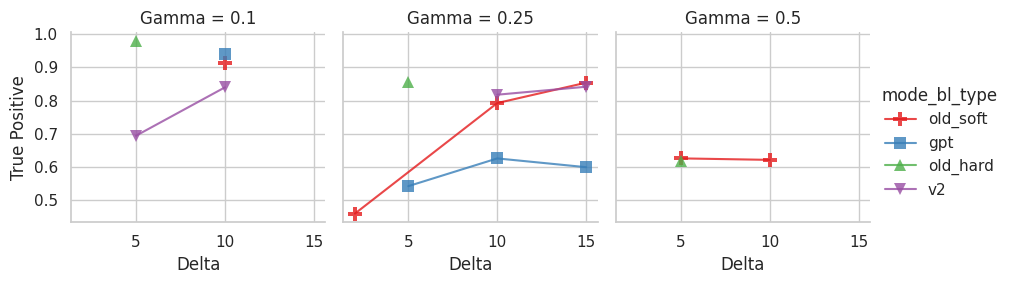

'for gamma, group in df_avg.groupby("gamma"):\n    print(f"Gamma: {gamma}") \n    display(group)'

<Figure size 640x480 with 0 Axes>

In [97]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def combine_mode_bl_type (x):
  if pd.isnull (x ['bl_type']):
    return x ['mode']
  else:
    return '_'.join ([x ['mode'], x ['bl_type']])

df_avg = pd.read_csv("z_score_avg.csv")
sns.set_theme(style="whitegrid")
rs = np.random.RandomState(4)
df_clean = df_avg.drop(df_avg[(df_avg["mode"] == "new") | (df_avg["mode"] == "no")].index)

df_clean['mode_bl_type'] = df_clean.apply(combine_mode_bl_type, axis=1)

# 创建一个分面网格图对象，按照gamma值分列绘制子图
# sns.lineplot(x="delta", y="true_positive", style="logic", markers=["o", "s", "d", "^"], data=df_clean)

g = sns.FacetGrid(df_clean, col="gamma", hue="mode_bl_type", palette="Set1", hue_kws={"marker": ["P", "s", "^", "v"], "markersize": [10, 8, 8, 8], "markeredgewidth": [0, 0, 0, 0], "alpha": [0.8, 0.8, 0.8, 0.8]})
g.map(sns.lineplot, "delta", "true_positive", marker=True, dashes=False)

g.set_axis_labels("Delta", "True Positive")
g.set_titles("Gamma = {col_name}")

g.add_legend()

plt.show()
plt.savefig("tulu.pdf")
# Run this cell to print subframes of a groupby object, no further action is needed
'''for gamma, group in df_avg.groupby("gamma"):
    print(f"Gamma: {gamma}") 
    display(group)'''

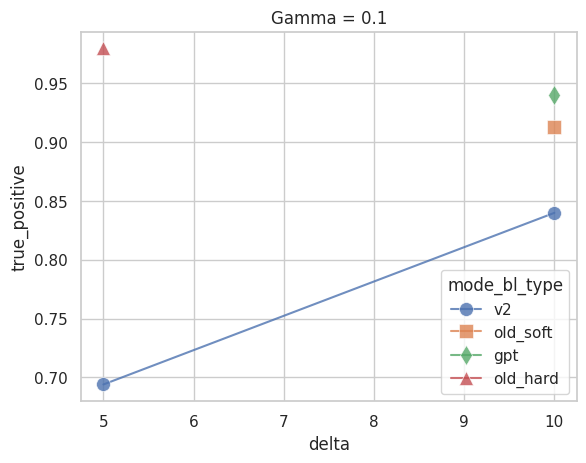

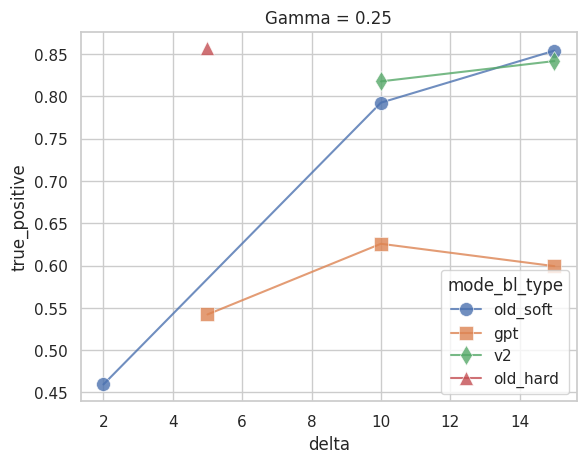

/tmp/ipykernel_792890/1059725138.py:3: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=group, x="delta", y="true_positive", hue="mode_bl_type", style="mode_bl_type", dashes=False, markers=['o', 's', 'd', '^'], markersize=10, markeredgewidth=0.5, alpha=0.8)


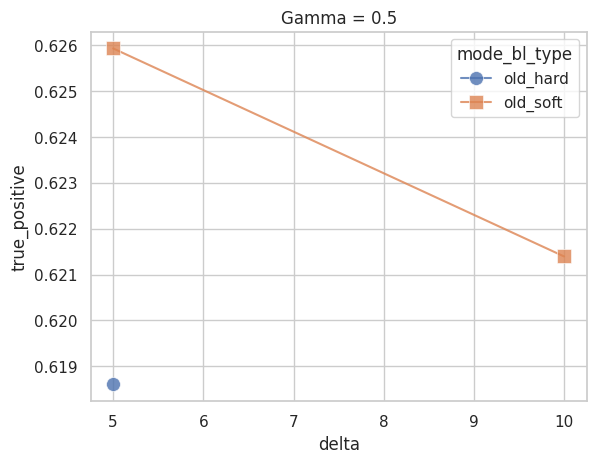

Gamma: 0.1


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
8,15,tulu-7b,v2,0.1,5.0,4,NaN,17.558167,0.694060,0.305940,2239,v2
11,17,tulu-7b,v2,0.1,10.0,4,NaN,26.872913,0.839879,0.160121,2317,v2
15,1,tulu-7b,old,0.1,10.0,4,soft,28.833215,0.912484,0.087516,2331,old_soft
16,6,tulu-7b,gpt,0.1,10.0,4,NaN,43.001146,0.939886,0.060114,2279,gpt
17,10,tulu-7b,old,0.1,5.0,4,hard,30.193229,0.979601,0.020399,2353,old_hard


Gamma: 0.25


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
1,16,tulu-7b,old,0.25,2.0,4,soft,4.216058,0.459508,0.540492,2235,old_soft
2,9,tulu-7b,gpt,0.25,5.0,4,NaN,7.831998,0.542258,0.457742,1763,gpt
3,11,tulu-7b,gpt,0.25,15.0,4,NaN,9.468343,0.599346,0.400654,1530,gpt
6,8,tulu-7b,gpt,0.25,10.0,4,NaN,9.700528,0.625782,0.374218,1598,gpt
9,2,tulu-7b,old,0.25,10.0,4,soft,15.598581,0.792558,0.207442,2338,old_soft
10,12,tulu-7b,v2,0.25,10.0,4,NaN,15.683216,0.817736,0.182264,2244,v2
12,0,tulu-7b,v2,0.25,15.0,4,NaN,15.792114,0.841752,0.158248,2237,v2
13,13,tulu-7b,old,0.25,15.0,4,soft,15.892835,0.854052,0.145948,2357,old_soft
14,4,tulu-7b,old,0.25,5.0,4,hard,16.298966,0.856658,0.143342,2358,old_hard


Gamma: 0.5


,Unnamed: 0,model_name,mode,gamma,delta,threshold,bl_type,z_score,true_positive,false_negative,sum,mode_bl_type
4,3,tulu-7b,old,0.5,5.0,4,hard,6.718462,0.618603,0.381397,2247,old_hard
5,14,tulu-7b,old,0.5,10.0,4,soft,6.657127,0.621394,0.378606,2253,old_soft
7,7,tulu-7b,old,0.5,5.0,4,soft,6.103884,0.625929,0.374071,2152,old_soft


In [93]:
def plot_group(group):
  # 绘制每个组的折线图，以delta为x轴，true_positive为y轴，mode为不同类型的折线
  sns.lineplot(data=group, x="delta", y="true_positive", hue="mode_bl_type", style="mode_bl_type", dashes=False, markers=['o', 's', 'd', '^'], markersize=10, markeredgewidth=0.5, alpha=0.8)
  plt.title("Gamma = {}".format(group.name))
  plt.show()

df_clean.groupby("gamma").apply(plot_group)

for gamma, group in df_clean.groupby("gamma"):
    print(f"Gamma: {gamma}") 
    display(group)
    
    # group.plot()
    # plt.xlabel("Delta")
    # plt.ylabel("True Positive")
    # plt.title("True Positive by Gamma")
    # plt.show()

    

[[ 1  2  2  2  1]
 [-1  0  0  1  0]
 [ 0  1  1  0 -1]
 [ 1  0  1  2  3]
 [-1 -2 -2 -2 -2]
 [ 1  1  2  1  2]
 [ 1  1  2  1  1]
 [ 1  2  1  0  1]
 [ 0  0 -1  0  0]
 [-1  0  1  1  2]
 [ 0 -1 -1 -1 -1]
 [-1 -2 -1  0  1]
 [ 1  2  1  2  3]
 [ 0  1  1  2  2]
 [-1 -1  0 -1 -2]
 [ 0  0 -1  0  0]
 [ 1  0  1  0  1]
 [-1 -2 -3 -3 -2]
 [ 0  0  0 -1  0]
 [ 1  0  1  2  1]]
[[ 0  1  1  1  0]
 [ 0  1  1  2  1]
 [ 0  1  1  0 -1]
 [ 0 -1  0  1  2]
 [ 0 -1 -1 -1 -1]
 [ 0  0  1  0  1]
 [ 0  0  1  0  0]
 [ 0  1  0 -1  0]
 [ 0  0 -1  0  0]
 [ 0  1  2  2  3]
 [ 0 -1 -1 -1 -1]
 [ 0 -1  0  1  2]
 [ 0  1  0  1  2]
 [ 0  1  1  2  2]
 [ 0  0  1  0 -1]
 [ 0  0 -1  0  0]
 [ 0 -1  0 -1  0]
 [ 0 -1 -2 -2 -1]
 [ 0  0  0 -1  0]
 [ 0 -1  0  1  0]]
    position  step  walk
0          0     0     0
1          1     1     0
2          1     2     0
3          1     3     0
4          0     4     0
..       ...   ...   ...
95         0     0    19
96        -1     1    19
97         0     2    19
98         1     3    19
99 

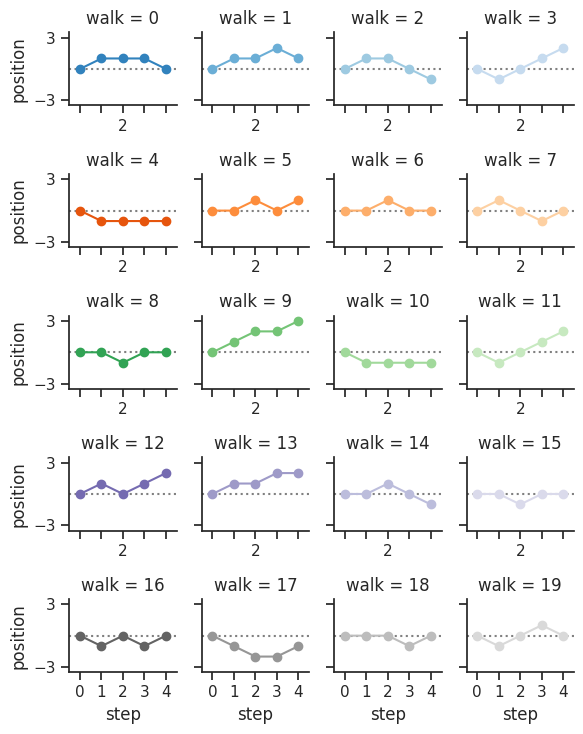

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
print(pos)
pos -= pos[:, 0, np.newaxis]
print(pos)
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

print(df)
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="walk", hue="walk", palette="tab20c",
                     col_wrap=4, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)